In [31]:
import pandas as pd
import numpy as np
import os

print("\nIniciando Limpeza de dados")

def ler_e_combinar_csvs(lista_de_caminhos):
    lista_de_dfs = []
    
    for caminho_arquivo in lista_de_caminhos:
        try:
            print(f"Lendo arquivo: {caminho_arquivo}")
            df_temp = pd.read_csv(caminho_arquivo,
                                  encoding='latin-1',
                                  sep=';')
            # CORREÇÃO: Esta linha deve estar dentro do 'try'
            lista_de_dfs.append(df_temp)
        except FileNotFoundError:
            print(f"ERRO: Arquivo não encontrado no caminho: {caminho_arquivo}. Pulando...")
        except Exception as e:
            print(f"ERRO: Ocorreu um erro ao ler o arquivo {caminho_arquivo}: {e}")
            
    if not lista_de_dfs:
        print("Nenhum arquivo CSV foi lido. Retornando com None.")
        return None

    df_combinado = pd.concat(lista_de_dfs, ignore_index=True)
    print("\nConcatenação concluída! DataFrame final criado.")
    return df_combinado        
    
def preencher_nulos_detalhamento(df, coluna_detalhamento):
    #Preenche os valores nulos em uma coluna de detalhamento com uma string padrão.
    df.loc[:, coluna_detalhamento] = df[coluna_detalhamento].fillna('Nenhum registro encontrado')
    return df

def preencher_nulos_documento(df, coluna_documento):
    #Preenche os valores nulos em uma coluna de documento com uma string padrão.
    df.loc[:, coluna_documento] = df[coluna_documento].fillna('s/n')
    return df

def limpar_e_converter_data(df, coluna_data):
    df[coluna_data] = pd.to_datetime(df[coluna_data], format='%d/%m/%Y', errors='coerce')
    return df
def converter_mes(df, coluna_mes):
    meses_mapeamento = {
    1: 'Janeiro',
    2: 'Fevereiro',
    3: 'Março',
    4: 'Abril',
    5: 'Maio',
    6: 'Junho',
    7: 'Julho',
    8: 'Agosto',
    9: 'Setembro',
    10: 'Outubro',
    11: 'Novembro',
    12: 'Dezembro'
    }

    df[coluna_mes] = df[coluna_mes].map(meses_mapeamento)
    return df


lista_de_caminhos = ['Dados/despesa_ceaps_2019.csv', 'Dados/despesa_ceaps_2020.csv', 'Dados/despesa_ceaps_2021.csv', 'Dados/despesa_ceaps_2022.csv']

print("Iniciando leitura e combinação dos arquivos...")
df_ceaps = ler_e_combinar_csvs(lista_de_caminhos)

if df_ceaps is not None:
    print("\nDataFrame combinado criado com sucesso! Iniciando a Limpeza...")
    print("\nDataFrame original antes da limpeza:")
    print(df_ceaps.info())

    # ORDEM DAS CHAMADAS
    df_ceaps = limpar_e_converter_data(df_ceaps, 'DATA')
    df_ceaps = preencher_nulos_documento(df_ceaps, 'DOCUMENTO')
    df_ceaps = preencher_nulos_detalhamento(df_ceaps, 'DETALHAMENTO')
    df_ceaps = converter_mes(df_ceaps, 'MES')
    # Removendo 'R$', pontos e substituindo a vírgula por ponto\n",
    df_ceaps['VALOR_REEMBOLSADO'] = df_ceaps['VALOR_REEMBOLSADO'].str.replace('R$', '', regex=False)
    df_ceaps['VALOR_REEMBOLSADO'] = df_ceaps['VALOR_REEMBOLSADO'].str.replace('.', '', regex=False)
    df_ceaps['VALOR_REEMBOLSADO'] = df_ceaps['VALOR_REEMBOLSADO'].str.replace(',', '.', regex=False)
    df_ceaps['VALOR_REEMBOLSADO'] = pd.to_numeric(df_ceaps['VALOR_REEMBOLSADO'])
    
    print("Pipeline de limpeza concluído!")
    print("\nVisualização do DataFrame final:")
    print(df_ceaps.head())
    print("\nInformações do DataFrame final (verifique os tipos de dados):")
    print(df_ceaps.info())
else:
    print("Falha ao criar o DataFrame. Verifique se os arquivos existem nos caminhos informados.")



Iniciando Limpeza de dados
Iniciando leitura e combinação dos arquivos...
Lendo arquivo: Dados/despesa_ceaps_2019.csv
Lendo arquivo: Dados/despesa_ceaps_2020.csv
Lendo arquivo: Dados/despesa_ceaps_2021.csv
Lendo arquivo: Dados/despesa_ceaps_2022.csv

Concatenação concluída! DataFrame final criado.

DataFrame combinado criado com sucesso! Iniciando a Limpeza...

DataFrame original antes da limpeza:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69356 entries, 0 to 69355
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ANO                69356 non-null  int64 
 1   MES                69356 non-null  int64 
 2   SENADOR            69356 non-null  object
 3   TIPO_DESPESA       69356 non-null  object
 4   CNPJ_CPF           69356 non-null  object
 5   FORNECEDOR         69356 non-null  object
 6   DOCUMENTO          66393 non-null  object
 7   DATA               69356 non-null  object
 8   DETALHAMENTO  

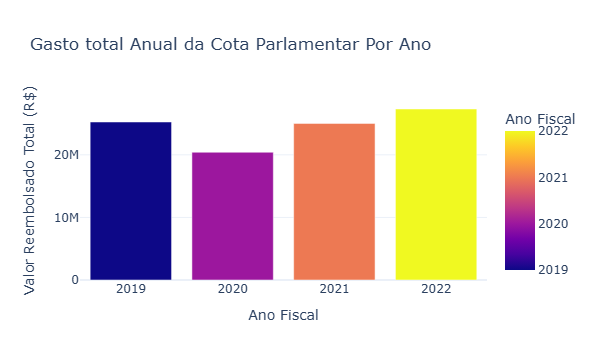

    ANO  VALOR_REEMBOLSADO
0  2019        25248242.40
1  2020        20414923.60
2  2021        25020323.84
3  2022        27323316.33
Os 3 senadores com maiores gastos totais são:
- TELMï¿½RIO MOTA
- ROGï¿½RIO CARVALHO
- MECIAS DE JESUS


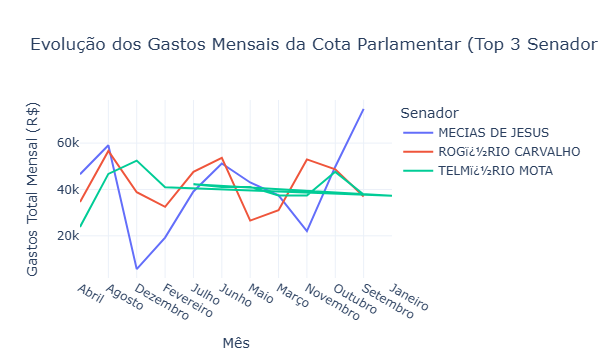

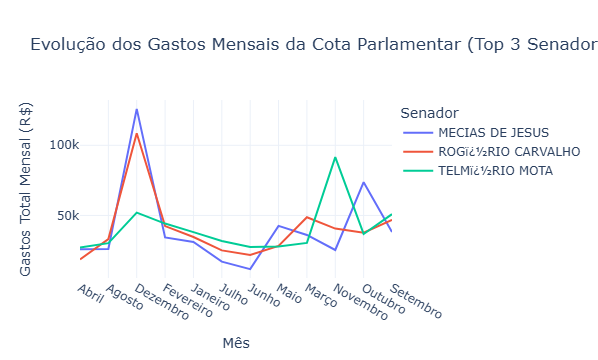

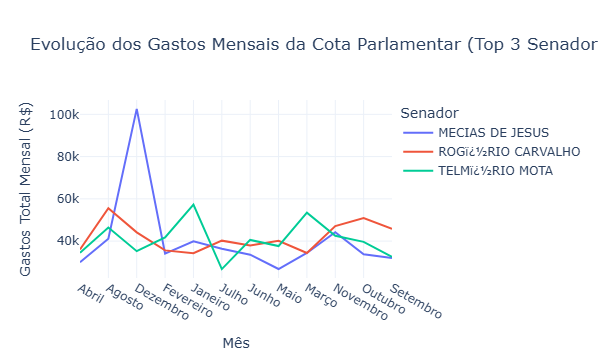

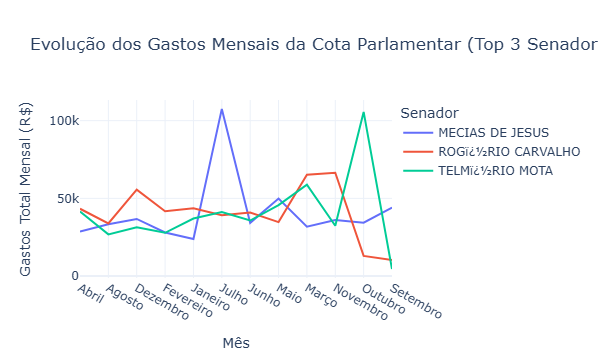

In [35]:
import plotly.express as px
import pandas as pd

gastos_por_ano = df_ceaps.groupby('ANO')['VALOR_REEMBOLSADO'].sum().reset_index() #Usei reset index para tornar a coluna 'ANO' regular

fig = px.bar(gastos_por_ano, x='ANO', y='VALOR_REEMBOLSADO', 
             title='Gasto total Anual da Cota Parlamentar Por Ano',
             labels={'ANO': 'Ano Fiscal', 'VALOR_REEMBOLSADO': 'Valor Reembolsado Total (R$)'},
             color='ANO',
             template='plotly_white')
fig.show()

print(gastos_por_ano)

gastos_totais_por_senador = df_ceaps.groupby('SENADOR')['VALOR_REEMBOLSADO'].sum()
top_3_senadores = gastos_totais_por_senador.nlargest(3).index.tolist()

print("Os 3 senadores com maiores gastos totais são:")
for senador in top_3_senadores:
    print(f"- {senador}")

df_top_3_senadores = df_ceaps[df_ceaps['SENADOR'].isin(top_3_senadores)]

anos_unicos = df_top_3_senadores['ANO'].unique()
for ano in sorted(anos_unicos):
    df_por_ano = df_top_3_senadores[df_top_3_senadores['ANO'] == ano]

    evolução_gastos_mensal = df_por_ano.groupby(['SENADOR', 'MES'])['VALOR_REEMBOLSADO'].sum().reset_index()
    
    fig = px.line(evolução_gastos_mensal, x='MES', y= 'VALOR_REEMBOLSADO',
                 color='SENADOR',
                 title=f'Evolução dos Gastos Mensais da Cota Parlamentar (Top 3 Senadores - {ano})',
                 labels={'MES': 'Mês',
                         'VALOR_REEMBOLSADO': 'Gastos Total Mensal (R$)',
                        'SENADOR': 'Senador'},
                 template='plotly_white')

    fig.show()
             